In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.grid_search import GridSearchCV
import matplotlib
matplotlib.style.use('ggplot')

# define random state to use
rs = 47

In [2]:
df = pd.read_csv('../../NYT_Reviews_Cleaned.csv')

In [3]:
# update publication date to datetime and set as index
df['publication_date'] = pd.to_datetime(df['publication_date'])
df.set_index('publication_date', inplace=True)

In [4]:
X = df['full_review_text']
y = df['critics_pick']

In [5]:
# check class balance
y.value_counts()/y.count()

0.0    0.794909
1.0    0.205091
Name: critics_pick, dtype: float64

In [6]:
# define a tokenizer that uses porter stemmer to get stems of words
stemmer = PorterStemmer()

def tokenize(s):
    words = word_tokenize(s)
    word_stems = []
    for word in words:
        word_stems.append(stemmer.stem(word))
    return word_stems

In [8]:
# create pipeline with CountVectorizer and MultinomialNB over which to gridsearch
pipe = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english', ngram_range=(1,2)), 
    MultinomialNB(alpha = 0.4)
)

In [12]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(countvectorizer__ngram_range= [(1,1),(1,2),(1,3),(1,4)], multinomialnb__alpha= [0.1,0.4,0.7])
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [13]:
# fit gridsearch
grid.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 12.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x11f8b42a8>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 2), preproce...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'multinomialnb__alpha': [0.1, 0.4, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [14]:
# print best score and parameters
print grid.best_score_
print grid.best_params_

0.682677377391
{'countvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.4}


In [93]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.8min finished


0.69538049265793123

### Try KNN

In [7]:
# create pipeline with CountVectorizer and kNN over which to gridsearch
pipe2 = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english', ngram_range = (1,1)), 
    KNeighborsClassifier(n_jobs=-1)
)

In [8]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(kneighborsclassifier__n_neighbors = [20,30,40])
grid2 = GridSearchCV(pipe2, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [9]:
# fit gridsearch
grid2.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:1060: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for s in gen_even_slices(Y.shape[0], n_jobs))
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:1060: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for s in gen_even_slices(Y.shape[0], n_jobs))
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:1060: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for s in gen_even_slices(Y.shape[0], n_jobs))
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:1060: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for s in gen_even_slices(Y.shape[0], n_jobs))
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:1060:

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x11ef90de8>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kneighborsclassifier__n_neighbors': [20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [10]:
# print best score and parameters
print grid2.best_score_
print grid2.best_params_

0.645828556884
{'kneighborsclassifier__n_neighbors': 30}


In [16]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe2, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.5min finished


0.68447573220433955

### Try SVM

In [11]:
# create pipeline with CountVectorizer and SVM over which to gridsearch
pipe3 = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, 
                    stop_words = 'english', ngram_range = (1,1)),
    SVC(kernel = 'rbf', C = 35, random_state = rs)
)

In [9]:
# below code was run iteratively over different ranges of values to find optimal parameters
param_grid = dict(countvectorizer__ngram_range = [(1,1),(1,2),(1,3),(1,4)])
grid3 = GridSearchCV(pipe3, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

In [10]:
# fit gridsearch
grid3.fit(X,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=<function tokenize at 0x11f98fde8>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...bf',
  max_iter=-1, probability=True, random_state=47, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [11]:
# print best score and parameters
print grid3.best_score_
print grid3.best_params_

0.784595092651
{'countvectorizer__ngram_range': (1, 1)}


In [12]:
# check cross validated score using optimal parameters in pipeline
cross_val_score(pipe3, X, y, cv=5, verbose = 1, scoring='roc_auc').mean()

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.8min finished


0.79571656257313417

In [15]:
# do train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
        stratify = y, test_size=0.2, random_state=rs)

In [18]:
svm_pipe = make_pipeline(
    CountVectorizer(strip_accents = 'ascii', analyzer = tokenize, stop_words = 'english'),
    SVC(kernel = 'rbf', C = 35, random_state = rs, probability=True)
)

In [19]:
svm_pipe.fit(X_train, y_train)
y_proba = svm_pipe.predict_proba(X_test)

In [20]:
svm_pipe.score(X_test, y_test)

0.8218040951853901

In [52]:
# function to plot ROC curve, where y_list is a list of lists with format:
# [y_test, y_proba, color (string), name (string)]
def plotROC(y_list, plotTitle):
    leg = []
    plt.figure(figsize= (7,7))
    for y_test, y_proba, color, name in y_list:
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
        plt.plot(fpr, tpr, color = color)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        leg.append(name)
    leg.append("Guessing")
    plt.plot([0,1],[0,1], 'w')
    plt.title(plotTitle)
    plt.legend(leg, loc = 'lower right', bbox_to_anchor=(1,0.5), borderaxespad=0.)
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)

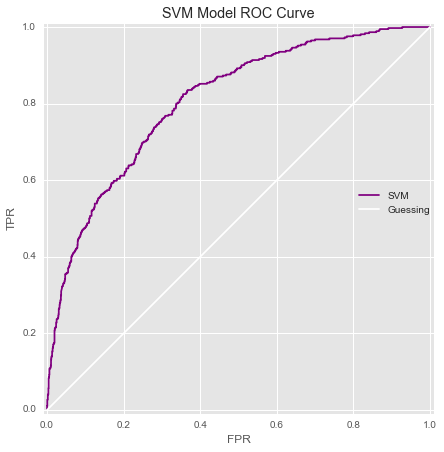

In [55]:
plotROC([[y_test, y_proba, 'purple', 'SVM']], 'SVM Model ROC Curve')
plt.savefig('../Images/SVM_Model_ROC_Curve.png')
plt.show()

In [46]:
# function to plot precision, FPR and TPR versus model probability threshold
def getPlotValueAdd(probas, y_test):
    # create dataframe with the model's predicted P(unhappy) along with boolean for actual unhappiness
    modelprobs = pd.DataFrame()
    modelprobs['Model_Prob_Positive'] = probas[:,1]
    modelprobs['Positive_True'] = y_test.as_matrix()

    # sort by P(Unhappy) and add columns for % Unhappy and % Happy people falling above that threshold
    modelprobs.sort_values(by='Model_Prob_Positive', axis=0, inplace=True, ascending=False)
    modelprobs['TPR'] = np.cumsum(modelprobs['Positive_True'])/np.sum(modelprobs['Positive_True'])
    modelprobs['FPR'] = np.cumsum(1-modelprobs['Positive_True'])/np.sum(1-modelprobs['Positive_True'])
    # add column with ratio of correct prediction (ie, precision for predicting unhappiness)
    modelprobs['Precision (portion of positive predictions correct)'] = np.cumsum(modelprobs['Positive_True'])/(np.cumsum(modelprobs['Positive_True']) + np.cumsum(1-modelprobs['Positive_True']))

    # Plot the difference
    plt.figure(figsize= (7,7))
    x = modelprobs['Model_Prob_Positive']
    y1 = modelprobs['TPR']
    y2 = modelprobs['FPR']
    y3 = modelprobs['Precision (portion of positive predictions correct)']
    plt.plot(x, y1, 'purple', x, y2, 'blue', x, y3, 'w')
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.xlabel("Model P(Positive) Threshold")
    plt.legend(["True Positive Rate", "False Positive Rate", "Precision"],loc = 'lower right', bbox_to_anchor=(1,0.5), borderaxespad=0.)


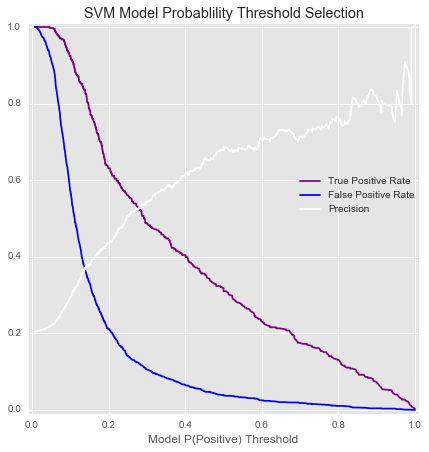

In [56]:
getPlotValueAdd(y_proba, y_test)
plt.title("SVM Model Probablility Threshold Selection")
plt.savefig('../Images/SVM_Model_P_Threshold.png')
plt.show()